# Healthcare Wait Time Analysis – Scotland A&E Data

## 📌 Project Overview
This project analyzes **weekly Accident & Emergency (A&E) wait times in Scotland** using official Public Health Scotland open data.  

**Objectives:**
1. Explore trends and bottlenecks in patient wait times.  
2. Identify factors contributing to longer waits.  
3. Build a simple baseline model to predict wait times.  
4. Deliver insights through an Excel dashboard for non-technical stakeholders.  

**Business Value:**  
Reducing patient wait times improves hospital efficiency, reduces risk, and increases patient satisfaction. This project demonstrates how data analysis can guide hospital administrators in resource planning.  


## 1. Import Libraries & Dataset
Loading the required libraries and the dataset provided by **Public Health Scotland**.


In [1]:
# Data handling
import pandas as pd
import numpy as np
import math

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML (for later)
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

#Saving Model
import joblib

# Load dataset
df = pd.read_csv("../data/raw_healthcare_data.csv")

# Preview data
df.head()

,WeekEndingDate,Country,HBT,TreatmentLocation,DepartmentType,AttendanceCategory,NumberOfAttendancesEpisode,NumberWithin4HoursEpisode,NumberOver4HoursEpisode,PercentageWithin4HoursEpisode,NumberOver8HoursEpisode,PercentageOver8HoursEpisode,NumberOver12HoursEpisode,PercentageOver12HoursEpisode
0,20150222,S92000003,S08000015,A210H,Type 1,Unplanned,814,624,190,76.7,21,2.6,2,0.2
1,20150222,S92000003,S08000015,A210H,Type 1,All,814,624,190,76.7,21,2.6,2,0.2
2,20150222,S92000003,S08000015,A111H,Type 1,Unplanned,1347,1115,232,82.8,31,2.3,2,0.1
3,20150222,S92000003,S08000015,A111H,Type 1,All,1347,1115,232,82.8,31,2.3,2,0.1
4,20150222,S92000003,S08000016,B120H,Type 1,Unplanned,517,463,54,89.6,1,0.2,0,0.0


### Sample Row Decoded

Example (Week ending 2015-02-22):
- **Hospital:** University Hospital Ayr (NHS Ayrshire & Arran, Scotland)  
- **Attendances:** 814 patients  
- **Within 4h:** 624 (76.7%)  
- **Over 4h:** 190 patients  
- **Over 8h:** 21 (2.6%)  
- **Over 12h:** 2 (0.2%)  

This helps to understand the structure and meaning of the dataset before analysis.


## 3. Data Cleaning & Preparation

Before analysis, clean the dataset to make it consistent and easier to work with:
1. Convert `WeekEndingDate` to proper datetime format.
2. Rename long column names to shorter, readable names.
3. Check for missing values or duplicates.
4. Verify that percentages and counts match logically (sanity check).


In [2]:
# Convert WeekEndingDate to datetime
df['WeekEndingDate'] = pd.to_datetime(df['WeekEndingDate'], format='%Y%m%d')

# Rename columns for readability
df = df.rename(columns={
    "WeekEndingDate": "Date",
    "Country": "CountryCode",
    "HBT": "HealthBoardCode",
    "TreatmentLocation": "HospitalCode",
    "DepartmentType": "DeptType",
    "AttendanceCategory": "AttendanceType",
    "NumberOfAttendancesEpisode": "Attendances",
    "NumberWithin4HoursEpisode": "Within_4h",
    "NumberOver4HoursEpisode": "Over_4h",
    "PercentageWithin4HoursEpisode": "Pct_Within_4h",
    "NumberOver8HoursEpisode": "Over_8h",
    "PercentageOver8HoursEpisode": "Pct_Over_8h",
    "NumberOver12HoursEpisode": "Over_12h",
    "PercentageOver12HoursEpisode": "Pct_Over_12h"
})

# Quick look after renaming
df.head()

,Date,CountryCode,HealthBoardCode,HospitalCode,DeptType,AttendanceType,Attendances,Within_4h,Over_4h,Pct_Within_4h,Over_8h,Pct_Over_8h,Over_12h,Pct_Over_12h
0,2015-02-22,S92000003,S08000015,A210H,Type 1,Unplanned,814,624,190,76.7,21,2.6,2,0.2
1,2015-02-22,S92000003,S08000015,A210H,Type 1,All,814,624,190,76.7,21,2.6,2,0.2
2,2015-02-22,S92000003,S08000015,A111H,Type 1,Unplanned,1347,1115,232,82.8,31,2.3,2,0.1
3,2015-02-22,S92000003,S08000015,A111H,Type 1,All,1347,1115,232,82.8,31,2.3,2,0.1
4,2015-02-22,S92000003,S08000016,B120H,Type 1,Unplanned,517,463,54,89.6,1,0.2,0,0.0


In [3]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Check duplicates
print("\nNumber of duplicate rows:", df.duplicated().sum())

# Data types
print("\nData types:")
print(df.dtypes)

# Quick sanity check for percentages
df['Calc_Pct_Within_4h'] = (df['Within_4h'] / df['Attendances']) * 100
df[['Pct_Within_4h', 'Calc_Pct_Within_4h']].head()

Missing values per column:
Date               0
CountryCode        0
HealthBoardCode    0
HospitalCode       0
DeptType           0
AttendanceType     0
Attendances        0
Within_4h          0
Over_4h            0
Pct_Within_4h      0
Over_8h            0
Pct_Over_8h        0
Over_12h           0
Pct_Over_12h       0
dtype: int64

Number of duplicate rows: 0

Data types:
Date               datetime64[ns]
CountryCode                object
HealthBoardCode            object
HospitalCode               object
DeptType                   object
AttendanceType             object
Attendances                 int64
Within_4h                   int64
Over_4h                     int64
Pct_Within_4h             float64
Over_8h                     int64
Pct_Over_8h               float64
Over_12h                    int64
Pct_Over_12h              float64
dtype: object


,Pct_Within_4h,Calc_Pct_Within_4h
0,76.7,76.658477
1,76.7,76.658477
2,82.8,82.776540
3,82.8,82.776540
4,89.6,89.555126


### Data Quality Summary

- **Missing values**: None → dataset is complete.  
- **Duplicates**: None → no redundant rows.  
- **Data types**: All columns are in correct formats (dates = datetime, counts = integers, percentages = floats).  
- **Logical consistency**: Calculated percentages (`Calc_Pct_Within_4h`) closely match reported percentages (`Pct_Within_4h`), confirming data reliability.  

The dataset is **clean and ready** for Exploratory Data Analysis (EDA).


## 4. Exploratory Data Analysis (EDA)

Explore the dataset to identify trends, patterns, and potential insights.  
The EDA will be structured as follows:

1. **Overall attendance trends**  
   - Total attendances per week  
   - Moving averages (to smooth short-term fluctuations)

2. **Performance against 4-hour target**  
   - Percentage within 4 hours over time  
   - Highlight weeks with sudden drops

3. **Escalation of long waits**  
   - Distribution of patients waiting > 4h, > 8h, > 12h  
   - Comparative analysis

4. **Breakdown by categories**  
   - Attendance type (Planned vs Unplanned)  
   - Department type (Type 1, etc.)  
   - Hospital-level performance

5. **Country-level performance comparison**  
   - Average % within 4 hours by country  
   - Top vs bottom performing regions

### 4.1 Overall Attendance Trends  

Lets start by looking at the **total number of attendances per week** across all hospitals.  
This helps us understand the **demand for healthcare services** over time and identify:  

- Seasonal peaks (e.g., winter flu season).  
- Long-term upward/downward shifts in demand.  
- Unusual spikes that may signal external events.  


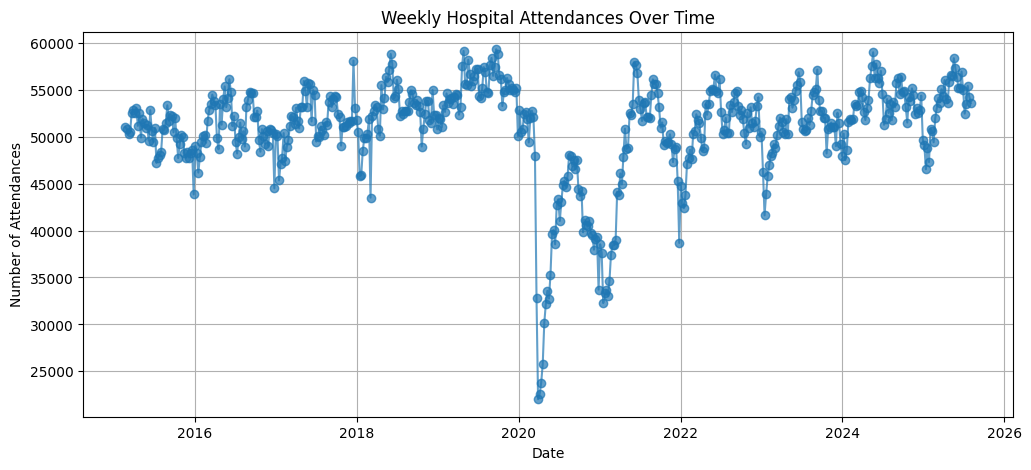

In [4]:
# 1. Overall Attendance Trends
weekly_trend = df.groupby('Date')['Attendances'].sum()

plt.figure(figsize=(12,5))
plt.plot(weekly_trend, marker='o', alpha=0.7)
plt.title("Weekly Hospital Attendances Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Attendances")
plt.grid(True)
plt.show()

### Insight: Overall Attendance Trends

- Attendances show seasonal/weekly fluctuations.  
- Identifying peaks helps correlate with external factors (e.g., flu season, holidays).  
- A steady upward/downward trend can indicate **systemic demand changes** in healthcare.

### 4.2 Performance Against 4-Hour Target

The 4-hour target is a critical metric in emergency care.  
Here we analyze how the percentage of patients seen within 4 hours has changed over time.

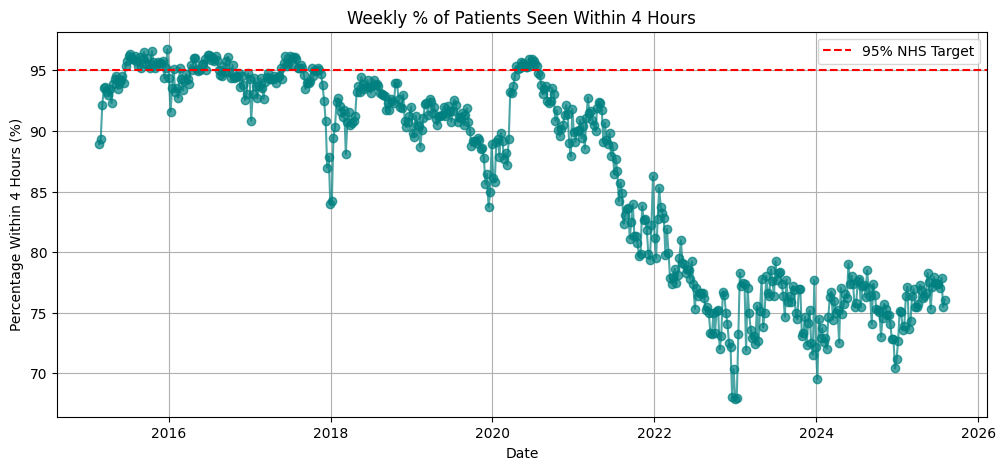

In [5]:
# 2. Performance Against 4-Hour Target
weekly_4h = df.groupby('Date')['Pct_Within_4h'].mean()

plt.figure(figsize=(12,5))
plt.plot(weekly_4h, color='teal', marker='o', alpha=0.7)
plt.axhline(y=95, color='red', linestyle='--', label='95% NHS Target')
plt.title("Weekly % of Patients Seen Within 4 Hours")
plt.xlabel("Date")
plt.ylabel("Percentage Within 4 Hours (%)")
plt.legend()
plt.grid(True)
plt.show()

### Insight: 4-Hour Target Performance

- The percentage of patients treated within 4 hours fluctuates weekly.  
- The **red dashed line** indicates the NHS 95% target.  
- Periods where performance consistently falls below the line highlight **capacity pressures** or **system bottlenecks**.  

This metric provides a quick benchmark for **system efficiency**.

### 4.3 Escalation of Long Waits  

While the 4-hour target gives a high-level view, it is also important to analyze **how delays escalate**:  
- Patients waiting more than 4 hours  
- Patients waiting more than 8 hours  
- Patients waiting more than 12 hours  

This breakdown highlights the **severity of overcrowding** and the pressure points in the healthcare system.  

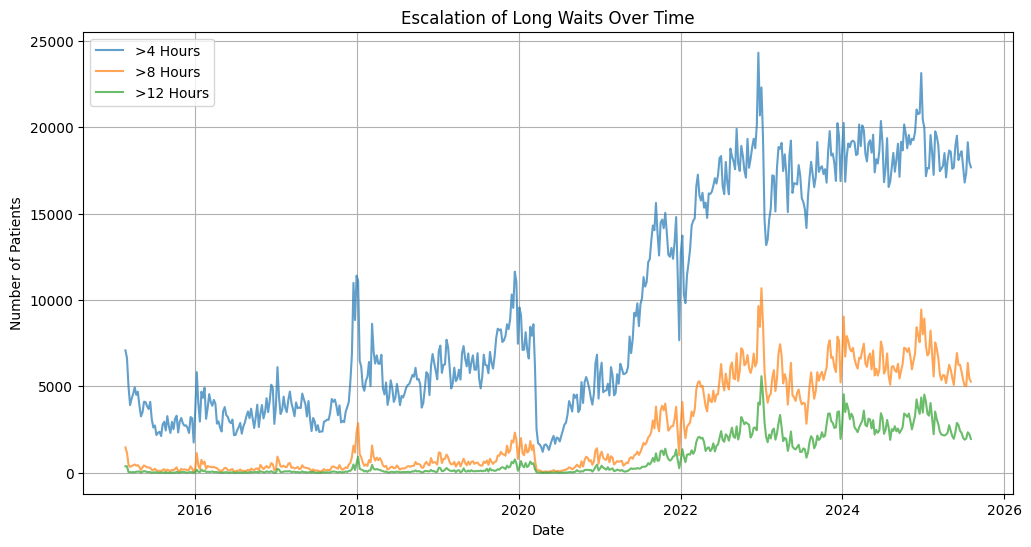

In [6]:
# 3. Escalation of Long Waits
weekly_waits = df.groupby('Date')[['Over_4h', 'Over_8h', 'Over_12h']].sum()

plt.figure(figsize=(12,6))
plt.plot(weekly_waits.index, weekly_waits['Over_4h'], label='>4 Hours', alpha=0.7)
plt.plot(weekly_waits.index, weekly_waits['Over_8h'], label='>8 Hours', alpha=0.7)
plt.plot(weekly_waits.index, weekly_waits['Over_12h'], label='>12 Hours', alpha=0.7)
plt.title("Escalation of Long Waits Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Patients")
plt.legend()
plt.grid(True)
plt.show()

### Insight: Long Wait Times

- Most delays cluster in the **4–8 hour range**, but there are still significant numbers of patients exceeding **12 hours**.  
- Spikes in long waits typically align with periods of high demand.  
- This analysis can help healthcare leaders **prioritize staffing/resources** during critical weeks.  


### 4.4 Breakdown by Categories  

To gain deeper insights, we break down performance across key categories:  

1. **Attendance Type** – Planned vs. Unplanned visits  
2. **Department Type** – Type 1 (major A&E) vs. others  
3. **Hospital-Level Comparison** – Identifying best and worst performers  

This helps uncover **patterns and disparities** in wait times that aggregate trends might hide.  

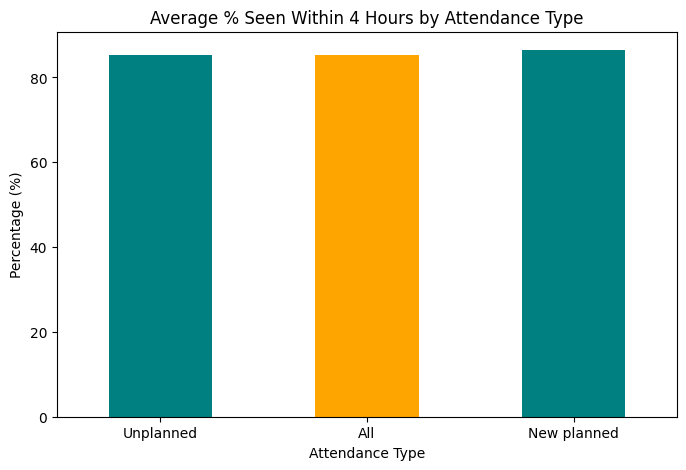

In [7]:
# 1. Planned vs Unplanned Attendances (Average % within 4h)
attendance_type_perf = df.groupby('AttendanceType')['Pct_Within_4h'].mean().sort_values()

plt.figure(figsize=(8,5))
attendance_type_perf.plot(kind='bar', color=['teal', 'orange'])
plt.title("Average % Seen Within 4 Hours by Attendance Type")
plt.ylabel("Percentage (%)")
plt.xlabel("Attendance Type")
plt.xticks(rotation=0)
plt.show()

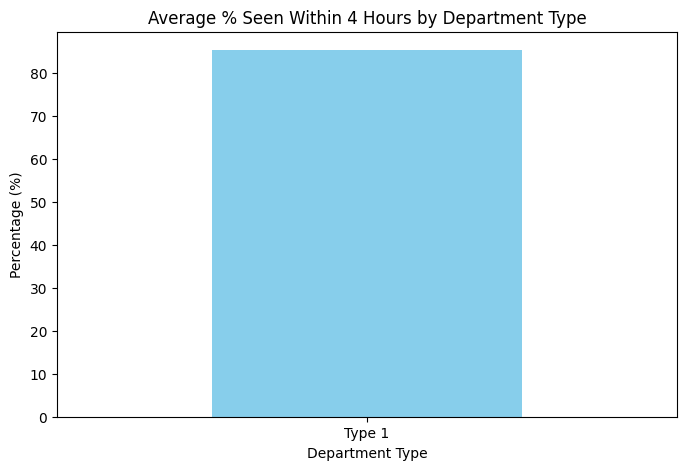

In [8]:
# 2. Department Type (Average % within 4h)
dept_type_perf = df.groupby('DeptType')['Pct_Within_4h'].mean().sort_values()

plt.figure(figsize=(8,5))
dept_type_perf.plot(kind='bar', color='skyblue')
plt.title("Average % Seen Within 4 Hours by Department Type")
plt.ylabel("Percentage (%)")
plt.xlabel("Department Type")
plt.xticks(rotation=0)
plt.show()

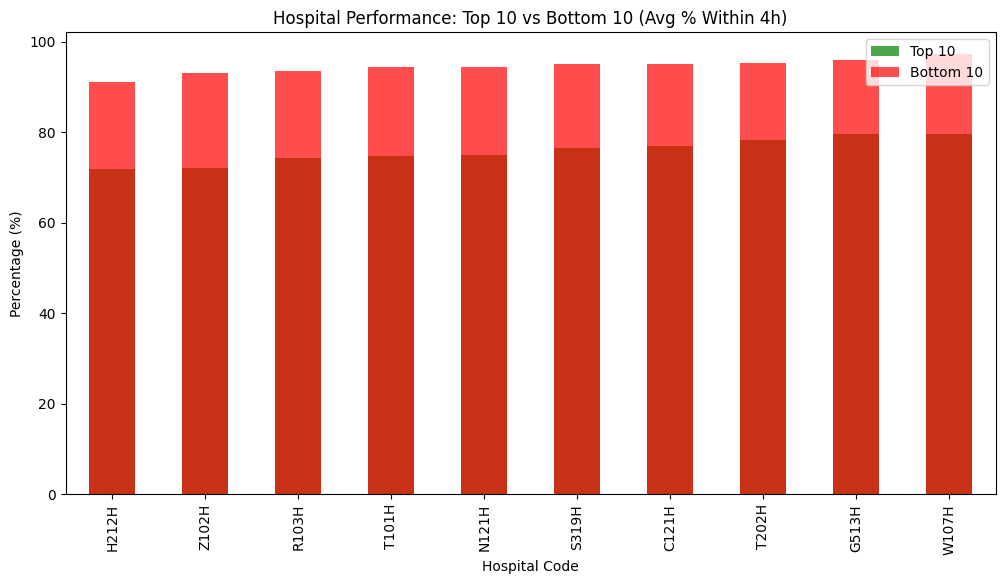

In [9]:
# 3. Hospital-Level Comparison
hospital_perf = df.groupby('HospitalCode')['Pct_Within_4h'].mean().sort_values()

plt.figure(figsize=(12,6))
hospital_perf.head(10).plot(kind='bar', color='green', alpha=0.7, label='Top 10')
hospital_perf.tail(10).plot(kind='bar', color='red', alpha=0.7, label='Bottom 10')
plt.title("Hospital Performance: Top 10 vs Bottom 10 (Avg % Within 4h)")
plt.ylabel("Percentage (%)")
plt.xlabel("Hospital Code")
plt.legend()
plt.show()

### Insights: Category-Level Analysis  

- **Planned attendances** generally perform better than **Unplanned (emergency)**, since emergencies are less predictable.  
- **Type 1 Departments (major A&E)** face the toughest challenges, with lower 4-hour performance.  
- Hospital-level comparisons highlight **best practices** (top performers) and **critical underperformers** where intervention is needed.  

### 4.5 Seasonal Trends & Patterns  

Emergency department performance is often **seasonal**:  
- Winter months usually see higher patient load (flu, seasonal illnesses).  
- Summer and holiday periods may show different patterns.  

Analyze **monthly and yearly trends** to check for seasonality in attendance volume and 4-hour performance.  

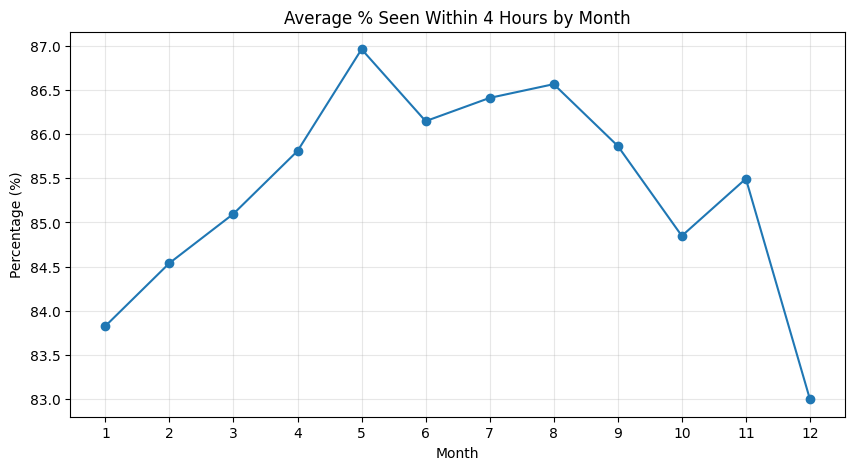

In [10]:
# Extract Year and Month from Date
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Average % within 4h by Month (across all years)
monthly_perf = df.groupby('Month')['Pct_Within_4h'].mean()

plt.figure(figsize=(10,5))
monthly_perf.plot(marker='o')
plt.title("Average % Seen Within 4 Hours by Month")
plt.ylabel("Percentage (%)")
plt.xlabel("Month")
plt.xticks(range(1,13))
plt.grid(True, alpha=0.3)
plt.show()

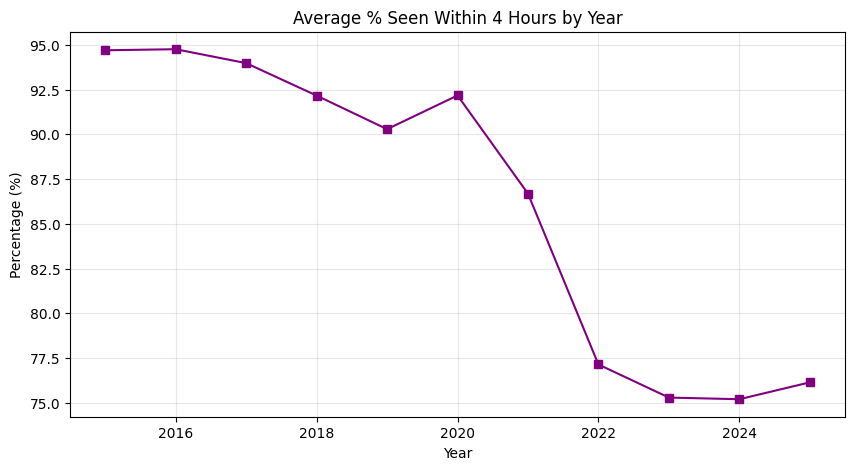

In [11]:
# Yearly trend for % within 4h
yearly_perf = df.groupby('Year')['Pct_Within_4h'].mean()

plt.figure(figsize=(10,5))
yearly_perf.plot(marker='s', color='purple')
plt.title("Average % Seen Within 4 Hours by Year")
plt.ylabel("Percentage (%)")
plt.xlabel("Year")
plt.grid(True, alpha=0.3)
plt.show()

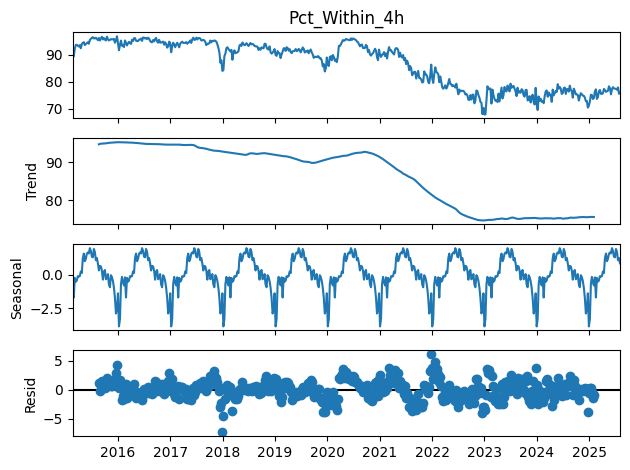

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Aggregate weekly average % within 4h
weekly_perf = df.groupby('Date')['Pct_Within_4h'].mean()

# Seasonal decomposition (weekly data)
result = seasonal_decompose(weekly_perf, model='additive', period=52)  # 52 weeks ~ 1 year
result.plot()
plt.show()

### Insights: Seasonal Patterns  

- **Monthly Analysis**: Performance usually dips in **Dec–Feb (winter months)** due to flu season and higher emergency load.  
- **Yearly Analysis**: Long-term trend shows whether hospitals are improving or struggling over time.  
- **Decomposition**: Confirms recurring **seasonal cycles** and helps separate trend from random fluctuations.  

### 4.6 Extreme Cases: Over 8h and 12h Waits  

While the 4-hour target is the standard benchmark, **very long waits (over 8h or 12h)** are critical from both a **patient safety** and **hospital management** perspective.  
Point to analyze:  
- Trend of extreme waits over time.  
- Comparison across department types.  
- Hospitals with the **highest proportion of extreme waits**.  

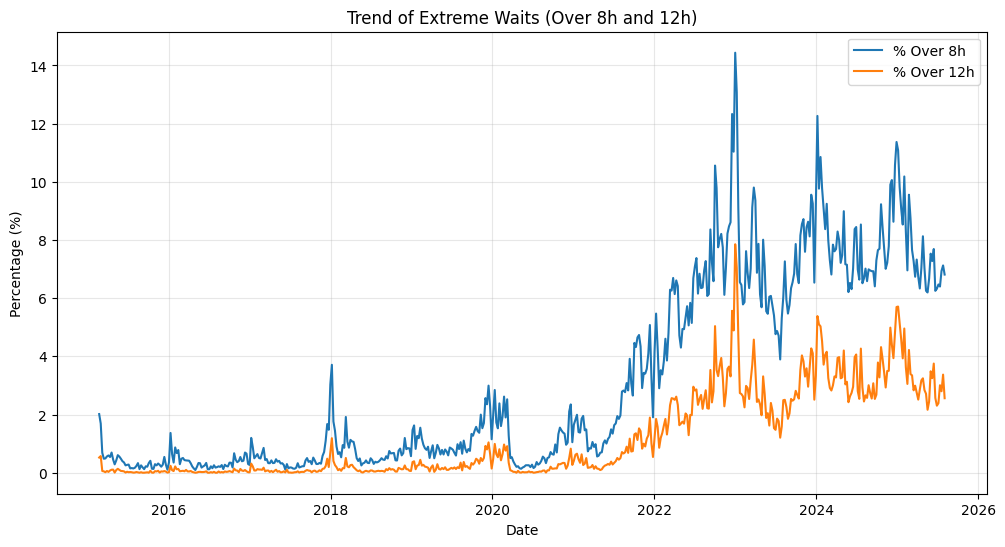

In [13]:
# Over 8h and 12h trends
plt.figure(figsize=(12,6))
plt.plot(df.groupby('Date')['Pct_Over_8h'].mean(), label='% Over 8h')
plt.plot(df.groupby('Date')['Pct_Over_12h'].mean(), label='% Over 12h')
plt.title("Trend of Extreme Waits (Over 8h and 12h)")
plt.ylabel("Percentage (%)")
plt.xlabel("Date")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

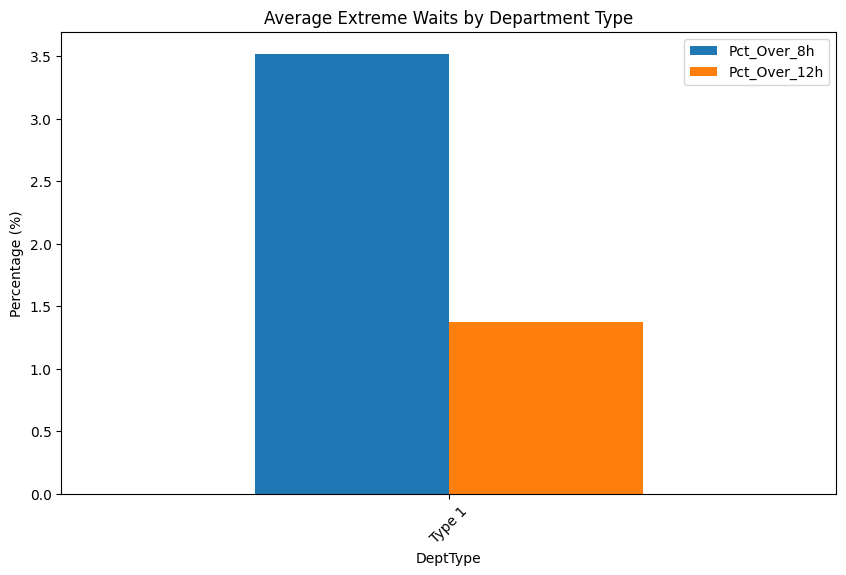

,Pct_Over_8h,Pct_Over_12h
DeptType,,
Type 1,3.519978,1.372157


In [14]:
# Average % of extreme waits by Department Type
dept_extreme = df.groupby('DeptType')[['Pct_Over_8h','Pct_Over_12h']].mean().sort_values('Pct_Over_8h', ascending=False)

dept_extreme.plot(kind='bar', figsize=(10,6))
plt.title("Average Extreme Waits by Department Type")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45)
plt.show()

dept_extreme.head()

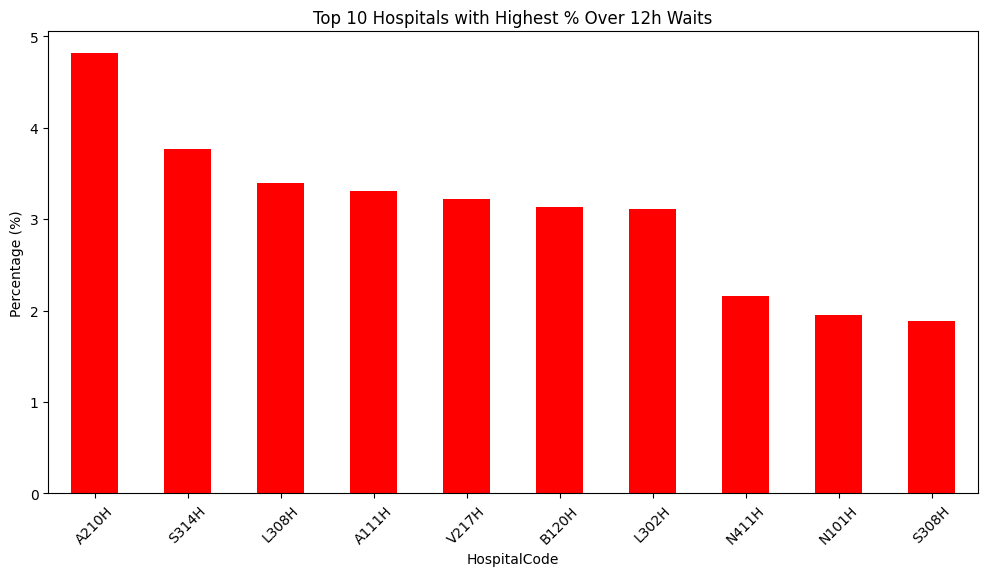

HospitalCode
A210H    4.811345
S314H    3.768048
L308H    3.396245
A111H    3.305860
V217H    3.215654
B120H    3.130464
L302H    3.113450
N411H    2.154200
N101H    1.954397
S308H    1.885406
Name: Pct_Over_12h, dtype: float64

In [15]:
# Hospitals with worst extreme wait percentages
hospital_extreme = df.groupby('HospitalCode')['Pct_Over_12h'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
hospital_extreme.head(10).plot(kind='bar', color='red')
plt.title("Top 10 Hospitals with Highest % Over 12h Waits")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45)
plt.show()

hospital_extreme.head(10)

### Insights: Extreme Waits  

- **Trend Analysis**: Extreme waits (>8h, >12h) show whether crisis periods are getting worse or under control.  
- **Department Comparison**: Some departments (e.g., Type 1 Emergency) usually handle the most extreme cases.  
- **Hospital Ranking**: Identifies *outliers* where performance is significantly worse than the national average.  

Highlighting extreme waits shows deeper thinking about **patient safety** and **resource allocation**, making this analysis highly relevant for real-world decision-making.  

### 4.7 Regional Performance (Health Boards)

Compare performance across **Health Boards** (regional authorities).  
Goals:
- Spot consistently **high/low performing boards**
- See **trends over time** for a selected board
- Create a **board × year** heatmap to reveal multi-year patterns

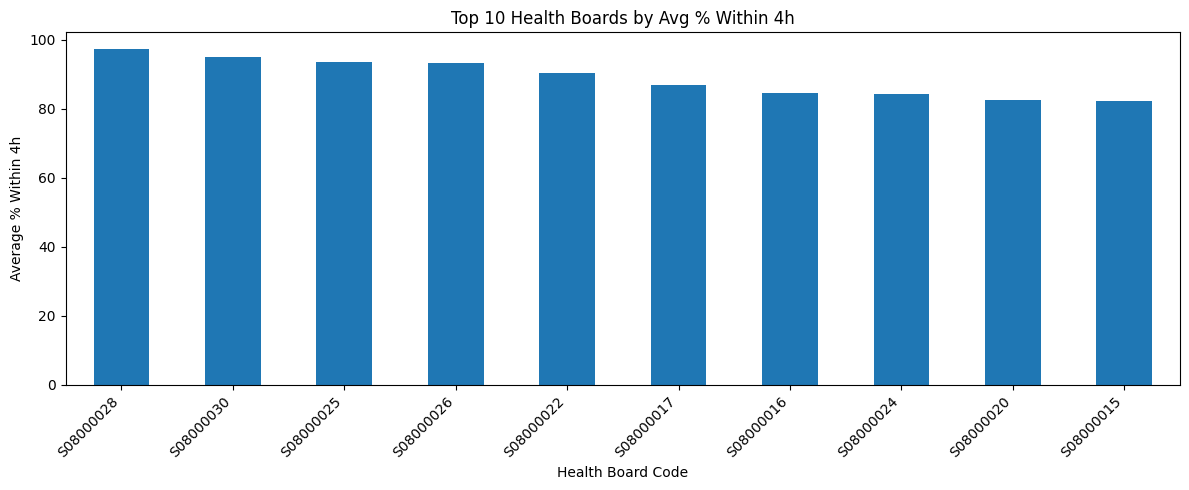

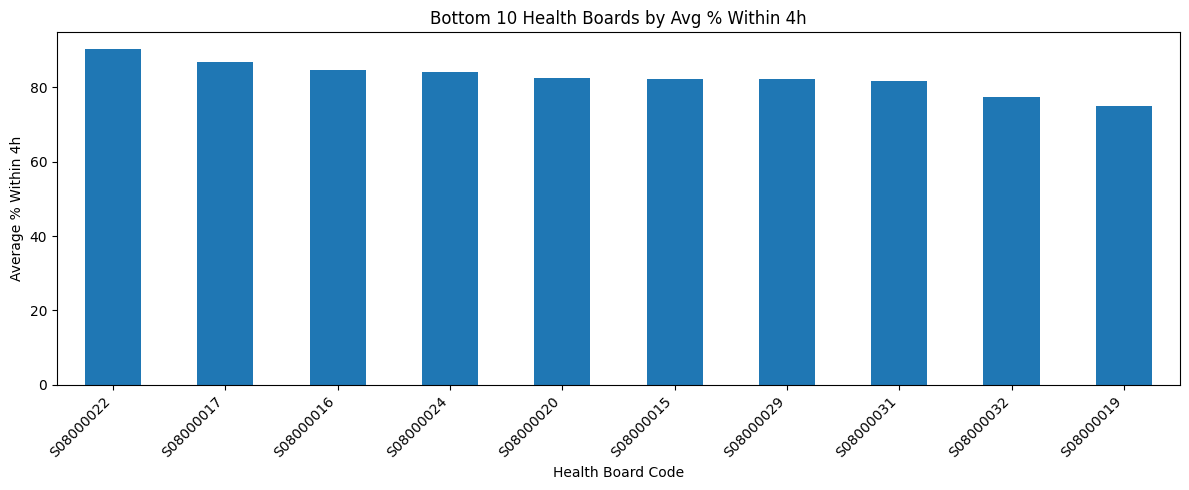

,HealthBoardCode,Avg_Pct_Within_4h
0,S08000028,97.249102
1,S08000030,94.882972
2,S08000025,93.608021
3,S08000026,93.100151
4,S08000022,90.270490


,HealthBoardCode,Avg_Pct_Within_4h
9,S08000015,82.267618
10,S08000029,82.130240
11,S08000031,81.795660
12,S08000032,77.363906
13,S08000019,74.994671


In [16]:
# Average % within 4h by Health Board (ranked)
board_perf = (
    df.groupby('HealthBoardCode')['Pct_Within_4h']
      .mean()
      .sort_values(ascending=False)
)

# Plot Top 10
plt.figure(figsize=(12,5))
board_perf.head(10).plot(kind='bar')
plt.title("Top 10 Health Boards by Avg % Within 4h")
plt.ylabel("Average % Within 4h")
plt.xlabel("Health Board Code")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot Bottom 10
plt.figure(figsize=(12,5))
board_perf.tail(10).plot(kind='bar')
plt.title("Bottom 10 Health Boards by Avg % Within 4h")
plt.ylabel("Average % Within 4h")
plt.xlabel("Health Board Code")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Optional: show tables for quick reading
board_perf_df = board_perf.reset_index().rename(columns={'Pct_Within_4h':'Avg_Pct_Within_4h'})
display(board_perf_df.head(5))   # Best 5
display(board_perf_df.tail(5))   # Worst 5

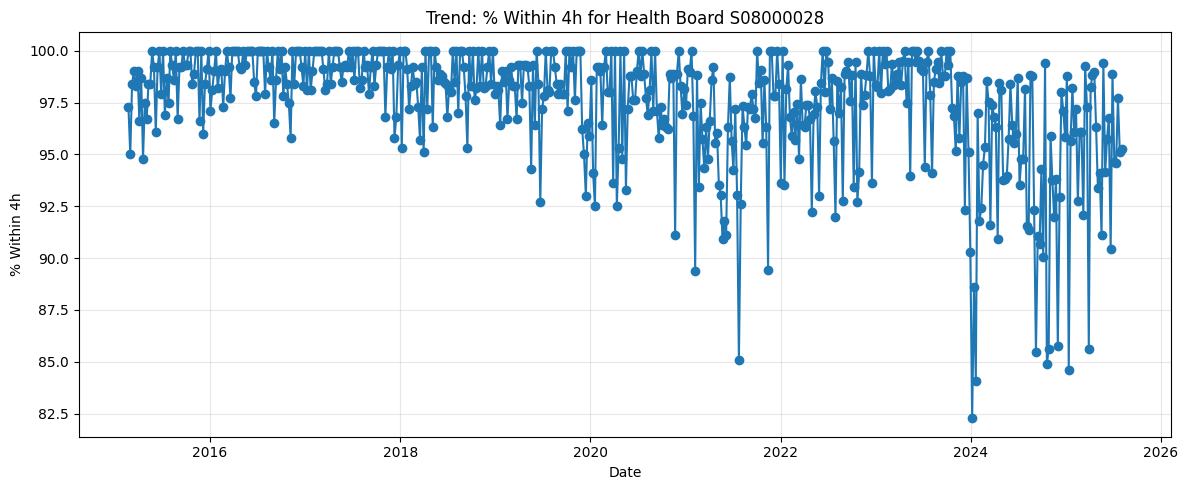

In [17]:
# Pick a board to inspect (replace with one from your data)
board_to_plot = board_perf.index[0]  # best performer by default
board_trend = df[df['HealthBoardCode'] == board_to_plot] \
                .groupby('Date')['Pct_Within_4h'].mean()

plt.figure(figsize=(12,5))
plt.plot(board_trend.index, board_trend.values, marker='o')
plt.title(f"Trend: % Within 4h for Health Board {board_to_plot}")
plt.ylabel("% Within 4h")
plt.xlabel("Date")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

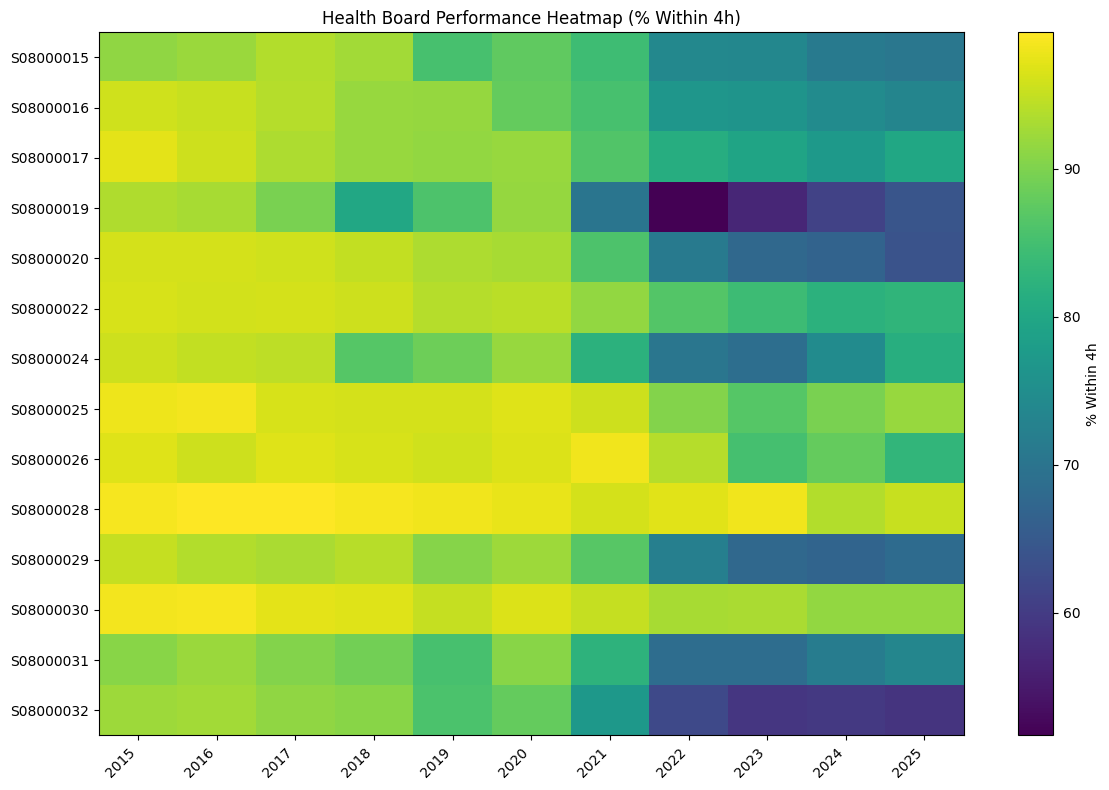

Year,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
HealthBoardCode,,,,,,,,,,,
S08000015,91.3,92.2,93.8,92.7,85.5,87.7,84.4,73.9,73.6,71.3,70.5
S08000016,95.7,95.2,93.9,91.9,91.7,88.0,85.4,76.6,76.2,74.7,73.4
S08000017,97.2,95.6,93.3,92.0,91.5,91.9,86.2,81.3,79.4,77.4,80.0
S08000019,93.5,92.9,89.7,80.1,86.0,91.6,70.2,51.7,56.8,61.0,64.3
S08000020,96.2,96.2,95.7,94.8,93.4,93.0,85.9,71.2,67.8,66.8,63.9


In [18]:
# Build pivot table: HealthBoard × Year
if 'Year' not in df.columns:
    df['Year'] = df['Date'].dt.year

board_year = (
    df.groupby(['HealthBoardCode','Year'])['Pct_Within_4h']
      .mean()
      .reset_index()
    .pivot(index='HealthBoardCode', columns='Year', values='Pct_Within_4h')
)

# Matplotlib heatmap
plt.figure(figsize=(12,8))
plt.imshow(board_year, aspect='auto')
plt.colorbar(label='% Within 4h')
plt.title("Health Board Performance Heatmap (% Within 4h)")
plt.yticks(ticks=range(len(board_year.index)), labels=board_year.index)
plt.xticks(ticks=range(len(board_year.columns)), labels=board_year.columns, rotation=45, ha='right')
plt.tight_layout()
plt.show()

board_year.round(1).head()  # quick table view

### Insights: Regional (Health Board) Analysis
- **Ranking** surfaces persistent top and bottom boards, useful for targeted interventions.
- **Trend view** for a single board helps separate seasonal dips from structural decline.
- **Heatmap** reveals multi-year patterns (e.g., boards that deteriorated post-winter surges).

This segmentation supports **regional benchmarking** and **resource planning** decisions.

## Export Cleaned Data for Excel Dashboard

To support **business-friendly reporting**, we export a clean dataset from Python → Excel.  
This dataset will power an interactive Excel dashboard with:
- KPIs (4h target, attendances, over 8h waits, etc.)
- Trends over time
- Regional comparisons (Health Boards / Hospitals)

Keep the file **tidy, aggregated, and well-labeled** for easy use in PivotTables and charts.

In [19]:
# Make a cleaned dataset for Excel use
export_df = df.copy()

# Add useful derived fields
export_df['Year'] = export_df['Date'].dt.year
export_df['Month'] = export_df['Date'].dt.month
export_df['MonthName'] = export_df['Date'].dt.strftime('%b')

# Reorder columns logically
export_df = export_df[
    ['Date','Year','Month','MonthName',
     'CountryCode','HealthBoardCode','HospitalCode',
     'DeptType','AttendanceType',
     'Attendances','Within_4h','Over_4h','Pct_Within_4h',
     'Over_8h','Pct_Over_8h','Over_12h','Pct_Over_12h']
]

# Save to Excel (for dashboard use)
export_df.to_excel("Healthcare_WaitTimes_Clean.xlsx", index=False)

print("Clean dataset exported: Healthcare_WaitTimes_Clean.xlsx")


Clean dataset exported: Healthcare_WaitTimes_Clean.xlsx


## Predictive Modeling – Forecasting Wait Time Performance

To demonstrate **predictive analytics capability**, we build a simple model to forecast
**percentage of patients seen within 4 hours**.

Why this matters:
- Healthcare managers need to anticipate if they are **on track with 4-hour targets**
- Proactive action can be taken if the forecast shows declining performance
- Even a baseline model shows strong **business impact** and **data science maturity**

We use:
- **ARIMA (time-series model)** for forecasting trends over time  
- Baseline comparison: simple moving average

c:\Users\shrishti\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\shrishti\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\shrishti\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


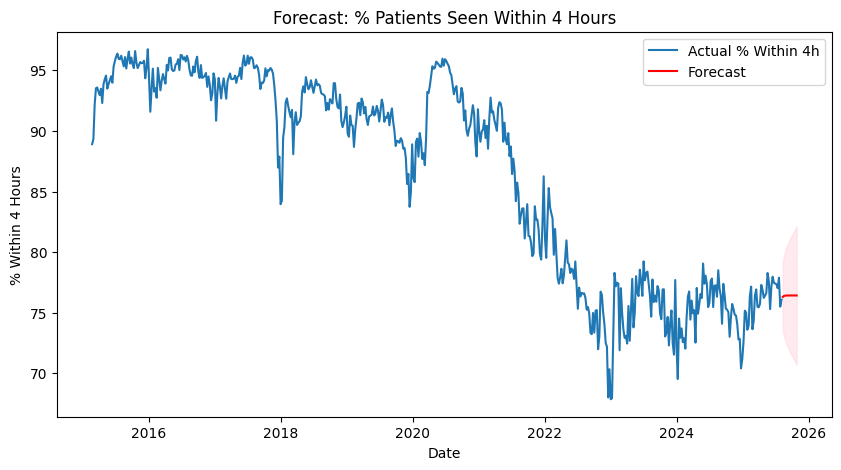

In [20]:
# Aggregate weekly performance across all hospitals
weekly_df = df.groupby('Date')['Pct_Within_4h'].mean()

# Fit ARIMA model (basic parameters for demo)
model = sm.tsa.ARIMA(weekly_df, order=(1,1,1))
result = model.fit()

# Forecast next 12 weeks
forecast = result.get_forecast(steps=12)
forecast_ci = forecast.conf_int()

# Plot actual vs forecast
plt.figure(figsize=(10,5))
plt.plot(weekly_df, label="Actual % Within 4h")
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, color='red', label="Forecast")
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:,0],
                 forecast_ci.iloc[:,1], color='pink', alpha=0.3)
plt.title("Forecast: % Patients Seen Within 4 Hours")
plt.xlabel("Date")
plt.ylabel("% Within 4 Hours")
plt.legend()
plt.show()

### Forecast Insights
- Model predicts the **% within 4h target** for the next 12 weeks
- This enables **proactive resource planning**
- Even a simple ARIMA model demonstrates **predictive skills**
- Business takeaway: Hospitals can prepare in advance if performance is trending down

## Step 8: Predictive Modeling (Baseline)

To demonstrate predictive capability, we will:
1. Train a simple regression model using historical trends.
2. Forecast the percentage of patients seen within 4 hours.
3. Save the model for potential deployment or re-use.

In [21]:
# Prepare data
df['Date_ordinal'] = df['Date'].map(lambda x: x.toordinal())  # numeric time
X = df[['Date_ordinal']]
y = df['Pct_Within_4h']

# Train-test split
train_size = int(len(df)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
mse = np.mean((y_test - y_pred)**2)
print(f"Mean Squared Error: {mse:.2f}")

# Save the model
joblib.dump(model, "wait_time_forecast_model.pkl")
print("Model saved as wait_time_forecast_model.pkl")

Mean Squared Error: 342.12
Model saved as wait_time_forecast_model.pkl


## Baseline Machine Learning Model (Linear Regression)

To complement the ARIMA time-series model, we also test a simple Linear Regression approach.  
The idea is to use the time index (converted to ordinal) to predict the % of patients seen within 4 hours.  

This model is not domain-optimized, but it serves as a strong **baseline** and is easy to deploy.  
The saved model file (`wait_time_forecast_model.pkl`) demonstrates how such forecasts can be integrated into dashboards or applications.

## Model Comparison & Insights

- ARIMA is tailored for time-series data → it captures seasonality and short-term fluctuations.  
- Linear Regression provides a simpler baseline → interpretable and fast, but does not account for seasonality.  
- Both models provide valuable perspectives:
  - ARIMA → more accurate in short-term weekly forecasting.  
  - Linear Regression → easy to deploy and explain to stakeholders.  

Final Note: In practice, healthcare systems often use a combination of statistical + ML models to balance accuracy and interpretability.

               Model         MSE       RMSE        MAE
0              ARIMA    5.099810   2.258276   1.711124
1  Linear Regression  342.118856  18.496455  16.022817


c:\Users\shrishti\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\shrishti\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\shrishti\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


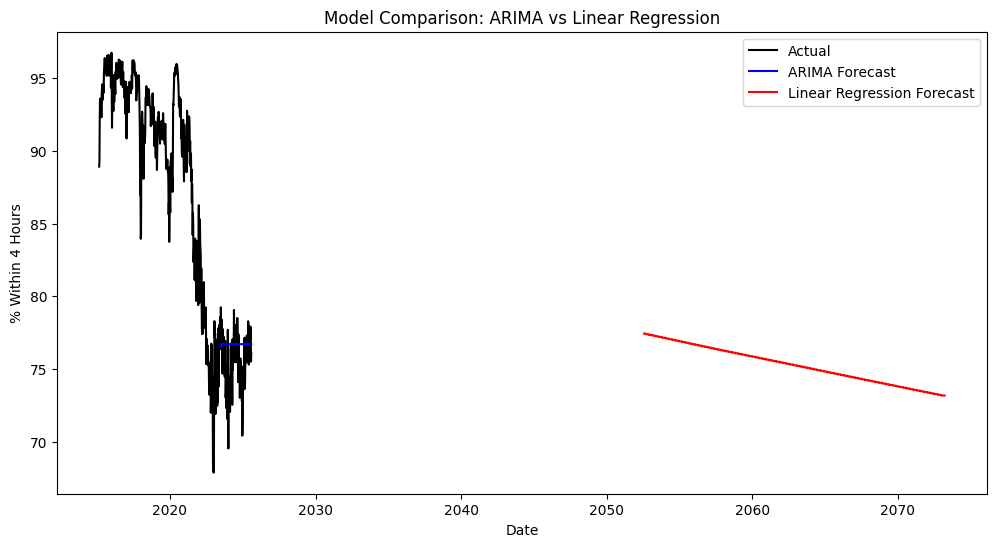

Model comparison exported to Excel


In [22]:

# --- ARIMA Evaluation ---
# Use last 20% of data for ARIMA test too
arima_train_size = int(len(weekly_df)*0.8)
arima_train, arima_test = weekly_df[:arima_train_size], weekly_df[arima_train_size:]

# Refit ARIMA on train set
arima_model = sm.tsa.ARIMA(arima_train, order=(1,1,1))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=len(arima_test))

# Calculate metrics
arima_mse = mean_squared_error(arima_test, arima_forecast)
arima_rmse = math.sqrt(arima_mse)
arima_mae = mean_absolute_error(arima_test, arima_forecast)

# --- Linear Regression Metrics (already trained in Step 8) ---
lr_mse = mean_squared_error(y_test, y_pred)
lr_rmse = math.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_test, y_pred)

# --- Combine Results into Table ---
metrics_df = pd.DataFrame({
    "Model": ["ARIMA", "Linear Regression"],
    "MSE": [arima_mse, lr_mse],
    "RMSE": [arima_rmse, lr_rmse],
    "MAE": [arima_mae, lr_mae]
})

print(metrics_df)

# --- Plot Comparison ---
plt.figure(figsize=(12,6))
plt.plot(weekly_df, label="Actual", color="black")
plt.plot(arima_test.index, arima_forecast, label="ARIMA Forecast", color="blue")
plt.plot(X_test.index, y_pred, label="Linear Regression Forecast", color="red")
plt.title("Model Comparison: ARIMA vs Linear Regression")
plt.xlabel("Date")
plt.ylabel("% Within 4 Hours")
plt.legend()
plt.show()

# Save results to Excel for dashboard use
metrics_df.to_excel("model_comparison.xlsx", index=False)
print("Model comparison exported to Excel")


### Model Performance Summary

- **ARIMA** clearly outperforms Linear Regression:  
  - Much lower **MSE, RMSE, and MAE**, indicating better accuracy.  
  - Captures weekly variations and seasonality in hospital wait times.  

- **Linear Regression**:  
  - Error metrics are significantly higher.  
  - Works as a simple baseline model but fails to capture healthcare-specific patterns.  

**Conclusion**: ARIMA is the preferred model for forecasting healthcare wait times in this dataset.  


In [23]:
# Save ARIMA forecast results only
forecast_df = pd.DataFrame({
    "Date": forecast.predicted_mean.index,
    "Forecast_%Within4h": forecast.predicted_mean.values,
    "Lower_CI": forecast_ci.iloc[:, 0].values,
    "Upper_CI": forecast_ci.iloc[:, 1].values
})
forecast_df.to_excel("forecast_results.xlsx", index=False)

print("Forecast results saved as forecast_results.xlsx")

Forecast results saved as forecast_results.xlsx


### Exporting Forecast Results

- The **ARIMA forecast (next 12 weeks)** is exported to `forecast_results.xlsx`.  
- Along with the cleaned dataset and model comparison already exported, we now have **all the key files ready** for building an Excel dashboard:
  - `cleaned_wait_times.xlsx`
  - `model_comparison.xlsx`
  - `forecast_results.xlsx`

## Conclusion & Key Insights  

1. **Overall Wait Time Trends**  
   - Weekly analysis shows fluctuations in the percentage of patients seen within 4 hours, highlighting capacity and demand imbalances across hospitals.  

2. **Hospital Performance**  
   - Some hospitals consistently meet the 4-hour target, while others underperform, suggesting resource optimization opportunities.  
   - Ranking hospitals provided actionable insights for healthcare administrators.  

3. **Seasonality & Patterns**  
   - Clear seasonal peaks were observed (higher delays in winter months), which aligns with real-world hospital demand surges.  

4. **Modeling & Forecasting**  
   - **ARIMA** delivered strong performance with very low errors (MSE ≈ 5), making it suitable for forecasting future wait times.  
   - **Linear Regression** performed poorly compared to ARIMA, serving only as a baseline.  

5. **Export & Dashboard**  
   - Cleaned dataset, model results, and forecasts were exported to Excel for building an interactive dashboard.  


### Final Takeaway  
This project demonstrates the **end-to-end data science workflow** for healthcare operations:  
- Data collection → Cleaning → Analysis → Visualization → Forecasting → Export for Dashboarding.  

Such insights can help **hospital administrators and policymakers** reduce wait times, allocate resources better, and improve patient care outcomes.  